In [1]:
import numpy as np
import pandas as pd
import os 
import statistics as stats
import math

from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from collections import defaultdict
import matplotlib.pyplot as plt


In [2]:
from pathlib import Path
# Set directories
working_dir = Path.cwd()
root_dir = working_dir.parent
data_dir = root_dir.joinpath('Data_Files')

# Read data and drop redundant column.
data = pd.read_csv(data_dir.joinpath('epl-training.csv'))
data = data.drop(labels="Referee",axis=1,inplace=False)
unname = "Unnamed"
for i in data.columns:
    if unname in i:
        data = data.drop(columns = [i])
        
#Calculate the difference

#FTG: The goals scored at full time
diff_FTG = data['FTHG'] - data['FTAG']
#HTG: The goals scored at half time
diff_HTG = data['HTHG'] - data['HTAG']
#S: Total number of shots on goal
diff_S = data['HS'] - data['AS']
#ST: Total number of shots on target
diff_ST = data['HST'] - data['AST']
#F: Total number of fouls committed
diff_F = data['HF'] - data['AF']
#C: Total number of corners
diff_C = data['HC'] - data['AC']
#Y: Total number of yellow cards
diff_Y = data['HY'] - data['AY']
#R: Total number of red cards
diff_R = data['HR'] - data['AR']

diff_data = pd.concat([data['Date'],data['HomeTeam'],data['AwayTeam'],diff_FTG,data['FTR'],diff_HTG,data['HTR'],diff_S,diff_ST,diff_F,diff_C,diff_Y,diff_R],axis=1,ignore_index=True)
diff_data.columns =["Date","HomeTeam","AwayTeam","diff_FTG","FTR","diff_HTG","HTR", "diff_S", "diff_ST", "diff_F", "diff_C", "diff_Y", "diff_R"]

df_epl = diff_data

In [3]:
df_epl.head()

,Date,HomeTeam,AwayTeam,diff_FTG,FTR,diff_HTG,HTR,diff_S,diff_ST,diff_F,diff_C,diff_Y,diff_R
0,2008/8/16,Arsenal,West Brom,1,H,1,H,19,10,3,2,0,0
1,2008/8/16,Bolton,Stoke,2,H,3,H,6,6,1,1,-1,0
2,2008/8/16,Everton,Blackburn,-1,A,0,D,-5,-6,2,-2,0,0
3,2008/8/16,Hull,Fulham,1,H,0,D,-1,0,1,-1,3,0
4,2008/8/16,Middlesbrough,Tottenham,1,H,0,D,6,5,-1,-2,-1,0


In [4]:
print(df_epl.shape)

(4940, 13)


In [5]:
df_epl['HomeTeamWonLast'] = False
last_match_winner =  defaultdict(int)

def home_team_won_last(row):

    home_team = row['HomeTeam']
    visitor_team = row['AwayTeam']
    
    
    teams = tuple(sorted([home_team,visitor_team]))
    if last_match_winner[teams] == 'H':
        result = 3 
    elif last_match_winner[teams] == 'D':
        result = 1
    else: 
        result = 0
    
    if row['FTR'] == 'H':
        winner = 'H'
    elif row['FTR'] == 'D':
        winner = 'D'
    else:
        winner = 'A'
#     elif row['FTR'] == 'A':
#         winner = row['AwayTeam']
    
    last_match_winner[teams] = winner
    
    return result

In [6]:
df_epl['HomeTeamWonLast'] = df_epl.apply(home_team_won_last, axis = 1)

In [7]:
df_epl.head()

,Date,HomeTeam,AwayTeam,diff_FTG,FTR,diff_HTG,HTR,diff_S,diff_ST,diff_F,diff_C,diff_Y,diff_R,HomeTeamWonLast
0,2008/8/16,Arsenal,West Brom,1,H,1,H,19,10,3,2,0,0,0
1,2008/8/16,Bolton,Stoke,2,H,3,H,6,6,1,1,-1,0,0
2,2008/8/16,Everton,Blackburn,-1,A,0,D,-5,-6,2,-2,0,0,0
3,2008/8/16,Hull,Fulham,1,H,0,D,-1,0,1,-1,3,0,0
4,2008/8/16,Middlesbrough,Tottenham,1,H,0,D,6,5,-1,-2,-1,0,0


In [8]:
epl_array = df_epl.to_numpy()
print(epl_array)
print(epl_array.shape)

[['2008/8/16' 'Arsenal' 'West Brom' ... 0 0 0]
 ['2008/8/16' 'Bolton' 'Stoke' ... -1 0 0]
 ['2008/8/16' 'Everton' 'Blackburn' ... 0 0 0]
 ...
 ['2021/5/23' 'Sheffield United' 'Burnley' ... 2 0 3]
 ['2021/5/23' 'West Ham' 'Southampton' ... -3 0 1]
 ['2021/5/23' 'Wolves' 'Man United' ... 3 0 3]]
(4940, 14)


In [9]:
epl_array.tolist()
# define a function that splits the dataset into separate datasets for each season

def get_season(year):
    season_database = []
    if year == '08':
        for i in range(380):
            season_database.append(epl_array[i])
    elif year == '09':
        for i in range(380,760):
            season_database.append(epl_array[i])
    elif year == '10':
        for i in range(760,1140):
            season_database.append(epl_array[i])
    elif year == '11':
        for i in range(1140,1520):
            season_database.append(epl_array[i])
    elif year == '12':
        for i in range(1520,1900):
            season_database.append(epl_array[i])
    elif year == '13':
        for i in range(1900,2280):
            season_database.append(epl_array[i])
    elif year == '14':
        for i in range(2280,2660):
            season_database.append(epl_array[i])
    elif year == '15':
        for i in range(2660,3040):
            season_database.append(epl_array[i])
    elif year == '16':
        for i in range(3040,3420):
            season_database.append(epl_array[i])
    elif year == '17':
        for i in range(3420,3800):
            season_database.append(epl_array[i])
    elif year == '18':
        for i in range(3800,4180):
            season_database.append(epl_array[i])
    elif year == '19':
        for i in range(4180,4560):
            season_database.append(epl_array[i])
    elif year == '20':
        for i in range(4560,4940):
            season_database.append(epl_array[i])
    return season_database

In [10]:
# create a function that returns a list with the teams competing in a particular season

def get_teams(year):
    epl_get_teams = get_season(year)
    teams = []
    for j in range(len(epl_get_teams)):
        if epl_get_teams[j][1] in teams:
            pass
        else:
            teams.append(epl_get_teams[j][1])
    return teams

In [11]:
# define a function that gives 3, 1, 0 (3 points for a win, 1 point for a draw, 0 for a loss) for the home team and 3,1,0 for the away team
# the first new column added has the home team points, while the second column has the away team points
# this is useful to then define a win streak feature later
def get_points(year):
    season_data = get_season(year)
    for i in range(len(season_data)):
        if season_data[i][4] == 'H':
            season_data[i] = np.append(season_data[i],3)
            season_data[i] = np.append(season_data[i],0)
        elif season_data[i][4] == 'D':
            season_data[i] = np.append(season_data[i],1)
            season_data[i] = np.append(season_data[i],1)
        elif season_data[i][4] == 'A':
            season_data[i] = np.append(season_data[i],0)
            season_data[i] = np.append(season_data[i],3)
    return season_data

In [12]:
# define a function that gives the win streak for each team in a particular season based on 5 previous games
# we will ignore the first 5 weeks of games since we have no data for the previous 5 games of the games in those weeks
def win_streak(year):
    season_data = get_points(year)
    teams = get_teams(year)
    for m in [1,2,3,4,5,10]:
        for team in teams:
            for i in range(m*10,len(season_data)):
                count = 0
                streak = 0
                x = 0
                if team == season_data[i][1]:
                    for j in range(1,i):
                        if (team == season_data[i-j][1]  and x < m):
                            streak = streak + season_data[i-j][14]
                            x += 1
                        elif (team == season_data[i-j][2] and x < m):
                            streak = streak + season_data[i-j][15]
                            x += 1
                    season_data[i] = np.append(season_data[i],streak)
        for team in teams:
            for i in range(m*10,len(season_data)):
                streak = 0
                count = 0
                x = 0
                if team == season_data[i][2]:
                    for j in range(1,i):
                        if (team == season_data[i-j][1]  and x < m):
                            streak = streak + season_data[i-j][14]
                            x += 1
                        elif (team == season_data[i-j][2] and x < m):
                            streak = streak + season_data[i-j][15]
                            x += 1
                    season_data[i] = np.append(season_data[i],streak)
    return season_data

In [13]:
# define a function that gives form for each team in a particular season based on 5 previous games (form is weighed more heavily if the team is playing the game at home)
# we ignore the first 5 weeks of the season since we have no data to calculate form
# first set of for loops calcualtes form for the home team, second set calculates it for the away team
# performance of the most recent game is weighed more, and so on for each previous performance

def get_form(year):
    season_data = win_streak(year)
    teams = get_teams(year)
    for m in [1,2,3,4,5,10]:
        for team in teams:
            for i in range(m*10,len(season_data)):
                x = 0
                goals_form = 0
                shots_form = 0
                corners_form = 0
                k = 5
                if team == season_data[i][1]:
                    for j in range(1,i):
                        if (team == season_data[i-j][1]  and x < m):
                            goals_form += k*season_data[i-j][3]
                            shots_form += k *season_data[i-j][7]
                            corners_form += k*season_data[i-j][10]
                            x += 1
                            k -= 1
                    form = 1.05*((3)*goals_form + (2)*shots_form + (1)*corners_form)/(3*(goals_form+shots_form+corners_form)+1)
                    season_data[i] = np.append(season_data[i],round(form,2))
        for team in teams:
            for i in range(m*10,len(season_data)):
                goals_form = 0
                shots_form = 0
                corners_form = 0
                x = 0
                k = 5
                if team == season_data[i][2]:
                    for j in range(1,i):
                        if (team == season_data[i-j][1]  and x < m):
                            goals_form += k*season_data[i-j][3]
                            shots_form += k*season_data[i-j][7]
                            corners_form += k*season_data[i-j][10]
                            x += 1
                            k -= 1
                    form = ((3)*goals_form + (2)*shots_form + (1)*corners_form)/(3*(goals_form+shots_form+corners_form)+1)
                    season_data[i] = np.append(season_data[i],round(form,2))
    return season_data

In [14]:
def get_g_s_st_c(year):
    season_data = get_form(year)
    teams = get_teams(year)
    for m in [1,3,5]:
        for team in teams:
            for i in range(m*10,len(season_data)):
                x = 0
                goals = 0
                shots = 0
                shots_target = 0
                corners = 0
                if team == season_data[i][1]:
                    for j in range(1,i):
                        if (team == season_data[i-j][1]  and x < m):
                            goals += season_data[i-j][3]
                            shots += season_data[i-j][7]
                            shots_target += season_data[i-j][8]
                            corners += season_data[i-j][10]
                            x += 1
                    season_data[i] = np.append(season_data[i],goals)
                    season_data[i] = np.append(season_data[i],shots)
                    season_data[i] = np.append(season_data[i],shots_target)
                    season_data[i] = np.append(season_data[i],corners)
        for team in teams:
            for i in range(m*10,len(season_data)):
                goals = 0
                shots = 0
                shots_target = 0
                corners = 0
                x = 0
                if team == season_data[i][2]:
                    for j in range(1,i):
                        if (team == season_data[i-j][1]  and x < m):
                            goals += season_data[i-j][3]
                            shots += season_data[i-j][7]
                            shots_target += season_data[i-j][8]
                            corners += season_data[i-j][10]
                            x += 1
                    season_data[i] = np.append(season_data[i],goals)
                    season_data[i] = np.append(season_data[i],shots)
                    season_data[i] = np.append(season_data[i],shots_target)
                    season_data[i] = np.append(season_data[i],corners)    
    return season_data

In [15]:
# define a function that penalizes a team if it got yellow cards or red cards in the previous match (red cards are weighed more)
def get_cards(year):
    season_data = get_g_s_st_c(year)
    teams = get_teams(year)
    for team in teams:
        for i in range(10,len(season_data)):
            x = 0
            red_cards = 0
            yellow_cards = 0
            if team == season_data[i][1]:
                for j in range(1,i):
                    if (team == season_data[i-j][1]  and x < 1):
                        yellow_cards += season_data[i-j][11]
                        red_cards += season_data[i-j][12]
                        x += 1
                cards = (5*red_cards + 2*yellow_cards)/10
                season_data[i] = np.append(season_data[i],round(cards,2))
    for team in teams:
        for i in range(10,len(season_data)):
            yellow_cards = 0
            red_cards = 0
            x = 0
            if team == season_data[i][2]:
                for j in range(1,i):
                    if (team == season_data[i-j][1]  and x < 1):
                        yellow_cards += season_data[i-j][11]
                        red_cards += season_data[i-j][12]
                        x += 1
                cards = (5*red_cards + 2*yellow_cards)/10
                season_data[i] = np.append(season_data[i],round(cards,2))
    return season_data



In [16]:
# scrape FIFA ratings from fifaindex.com for each season
ratings = []
urls = ['fifa09_5', 'fifa10_6', 'fifa11_7', 'fifa12_8', 'fifa13_11', 'fifa14_12', 'fifa15_16', 'fifa16_19', 'fifa17_74', 'fifa18_175','fifa19_280','fifa20_358', 'fifa21_421']
for item in urls:
    url = 'https://www.fifaindex.com/teams/' + item +'/?league=13&order=desc'
    ratings.append(pd.read_html(url)) # Returns list of all tables on page
print(ratings)

[[    Unnamed: 0               Name                   League   ATT   MID   DEF  \
0          NaN                NaN                      NaN   NaN   NaN   NaN   
1          NaN                NaN                      NaN   NaN   NaN   NaN   
2          NaN            Chelsea  Barclays Premier League  87.0  85.0  84.0   
3          NaN  Manchester United  Barclays Premier League  86.0  85.0  84.0   
4          NaN            Arsenal  Barclays Premier League  85.0  83.0  83.0   
5          NaN          Liverpool  Barclays Premier League  85.0  83.0  80.0   
6          NaN    Manchester City  Barclays Premier League  82.0  79.0  78.0   
7          NaN                NaN                      NaN   NaN   NaN   NaN   
8          NaN                NaN                      NaN   NaN   NaN   NaN   
9          NaN  Tottenham Hotspur  Barclays Premier League  80.0  80.0  79.0   
10         NaN            Everton  Barclays Premier League  82.0  75.0  78.0   
11         NaN        Aston Villa  Bar

In [17]:
# clean up the scraped data (FIFA ratings) and divide it for each season
for i in range(13):
    ratings[i] = np.array(ratings[i])
    ratings[i] = ratings[i].reshape(28,100)
    ratings[i] = np.delete(ratings[i], slice(7,100),axis=1)
    ratings[i] = np.delete(ratings[i], [0,2],axis=1)
    ratings[i] = np.delete(ratings[i], [0,1,7,8,14,15,21,22],axis=0)

In [18]:
# rename the teams in the ratings dataset so that the names match with those in the dataset that was provided initially
# for example, the ratings dataset has "Manchester City" while the original dataset has "Man City"
# making the names match is useful for the functions that will be used later on
ratings = np.array(ratings)
print(ratings[11])
for i in range(13):
    for j in range (20):
        if ratings[i][j][0] == 'Manchester United':
            ratings[i][j][0] = 'Man United'
        if ratings[i][j][0] == 'Manchester City':
            ratings[i][j][0] = 'Man City'
        if ratings[i][j][0] == 'Tottenham Hotspur':
            ratings[i][j][0] = 'Tottenham'
        if ratings[i][j][0] == 'Newcastle United':
            ratings[i][j][0] = 'Newcastle'
        if ratings[i][j][0] == 'Blackburn Rovers':
            ratings[i][j][0] = 'Blackburn'
        if ratings[i][j][0] == 'West Ham United':
            ratings[i][j][0] = 'West Ham'
        if ratings[i][j][0] == 'Bolton Wanderers':
            ratings[i][j][0] = 'Bolton'
        if ratings[i][j][0] == 'Wigan Athletic':
            ratings[i][j][0] = 'Wigan'
        if ratings[i][j][0] == 'Hull City':
            ratings[i][j][0] = 'Hull'
        if ratings[i][j][0] == 'West Bromwich':
            ratings[i][j][0] = 'West Brom'
        if ratings[i][j][0] == 'West Bromwich Albion':
            ratings[i][j][0] = 'West Brom'
        if ratings[i][j][0] == 'Stoke City':
            ratings[i][j][0] = 'Stoke'
        if ratings[i][j][0] == 'Wolverhampton Wanderers':
            ratings[i][j][0] = 'Wolves'
        if ratings[i][j][0] == 'Birmingham City':
            ratings[i][j][0] = 'Birmingham'
        if ratings[i][j][0] == 'Queens Park Rangers':
            ratings[i][j][0] = 'QPR'
        if ratings[i][j][0] == 'Swansea City':
            ratings[i][j][0] = 'Swansea'
        if ratings[i][j][0] == 'Norwich City':
            ratings[i][j][0] = 'Norwich'
        if ratings[i][j][0] == 'Cardiff City':
            ratings[i][j][0] = 'Cardiff'
        if ratings[i][j][0] == 'Leicester City':
            ratings[i][j][0] = 'Leicester'
        if ratings[i][j][0] == 'Huddersfield Town':
            ratings[i][j][0] = 'Huddersfield'
        if ratings[i][j][0] == 'Brighton & Hove Albion':
            ratings[i][j][0] = 'Brighton'
        if ratings[i][j][0] == 'AFC Bournemouth':
            ratings[i][j][0] = 'Bournemouth'
        if ratings[i][j][0] == 'Leeds United':
            ratings[i][j][0] = 'Leeds' 
        

[['Manchester City' 86.0 87.0 83.0 86.0]
 ['Liverpool' 86.0 83.0 84.0 84.0]
 ['Tottenham Hotspur' 86.0 83.0 82.0 83.0]
 ['Arsenal' 86.0 82.0 80.0 81.0]
 ['Manchester United' 83.0 79.0 80.0 81.0]
 ['Chelsea' 79.0 84.0 80.0 81.0]
 ['Everton' 77.0 79.0 80.0 79.0]
 ['West Ham United' 83.0 79.0 76.0 78.0]
 ['Leicester City' 79.0 77.0 77.0 78.0]
 ['Wolverhampton Wanderers' 77.0 80.0 77.0 78.0]
 ['Watford' 77.0 79.0 76.0 78.0]
 ['AFC Bournemouth' 79.0 77.0 76.0 77.0]
 ['Newcastle United' 78.0 76.0 76.0 77.0]
 ['Crystal Palace' 75.0 77.0 76.0 77.0]
 ['Burnley' 77.0 76.0 76.0 76.0]
 ['Brighton & Hove Albion' 76.0 76.0 75.0 76.0]
 ['Southampton' 75.0 76.0 76.0 76.0]
 ['Aston Villa' 76.0 75.0 74.0 75.0]
 ['Norwich City' 76.0 73.0 72.0 74.0]
 ['Sheffield United' 73.0 73.0 73.0 73.0]]


In [19]:
# define  a function that splits the ratings array into separate arrays for each season
def get_season_ratings(year):
    season_database = []
    if year == '08':
        season_database.append(ratings[0])
    elif year == '09':
        season_database.append(ratings[1])
    elif year == '10':
        season_database.append(ratings[2])
    elif year == '11':
        season_database.append(ratings[3])
    elif year == '12':
        season_database.append(ratings[4])
    elif year == '13':
        season_database.append(ratings[5])
    elif year == '14':
        season_database.append(ratings[6])
    elif year == '15':
        season_database.append(ratings[7])
    elif year == '16':
        season_database.append(ratings[8])
    elif year == '17':
        season_database.append(ratings[9])
    elif year == '18':
        season_database.append(ratings[10])
    elif year == '19':
        season_database.append(ratings[11])
    elif year == '20':
        season_database.append(ratings[12])
    return season_database


In [20]:
#define a function that adds attack ratings for each team every season
def get_att(year):
    season_data = get_cards(year)
    season_rating = get_season_ratings(year)
    teams = get_teams(year)
    for team in teams:
        for i in range(len(season_data)):
            for j in range(20):
                if team == season_data[i][1] and team == season_rating[0][j][0]:
                    attack_rating = season_rating[0][j][1] 
                    season_data[i] = np.append(season_data[i],attack_rating)
    for team in teams:
        for i in range(len(season_data)):
            for j in range(20):
                if team == season_data[i][2] and team == season_rating[0][j][0]:
                    attack_rating = season_rating[0][j][1] 
                    season_data[i] = np.append(season_data[i],attack_rating)
    return season_data



In [21]:
#define a function that adds midfield ratings for each team every season
def get_mid(year):
    season_data = get_att(year)
    season_rating = get_season_ratings(year)
    teams = get_teams(year)
    for team in teams:
        for i in range(len(season_data)):
            for j in range(20):
                if team == season_data[i][1] and team == season_rating[0][j][0]:
                    mid_rating = season_rating[0][j][2] 
                    season_data[i] = np.append(season_data[i],mid_rating)
    for team in teams:
        for i in range(len(season_data)):
            for j in range(20):
                if team == season_data[i][2] and team == season_rating[0][j][0]:
                    mid_rating = season_rating[0][j][2] 
                    season_data[i] = np.append(season_data[i],mid_rating)
    return season_data




In [22]:
#define a function that adds defense ratings for each team every season
def get_def(year):
    season_data = get_mid(year)
    season_rating = get_season_ratings(year)
    teams = get_teams(year)
    for team in teams:
        for i in range(len(season_data)):
            for j in range(20):
                if team == season_data[i][1] and team == season_rating[0][j][0]:
                    def_rating = season_rating[0][j][3] 
                    season_data[i] = np.append(season_data[i],def_rating)
    for team in teams:
        for i in range(len(season_data)):
            for j in range(20):
                if team == season_data[i][2] and team == season_rating[0][j][0]:
                    def_rating = season_rating[0][j][3] 
                    season_data[i] = np.append(season_data[i],def_rating)
    return season_data




In [23]:
#define a function that adds overall ratings for each team every season

def get_ovr(year):
    season_data = get_def(year)
    season_rating = get_season_ratings(year)
    teams = get_teams(year)
    for team in teams:
        for i in range(len(season_data)):
            for j in range(20):
                if team == season_data[i][1] and team == season_rating[0][j][0]:
                    ovr_rating = season_rating[0][j][4] 
                    season_data[i] = np.append(season_data[i],ovr_rating)
    for team in teams:
        for i in range(len(season_data)):
            for j in range(20):
                if team == season_data[i][2] and team == season_rating[0][j][0]:
                    ovr_rating = season_rating[0][j][4] 
                    season_data[i] = np.append(season_data[i],ovr_rating)
    return season_data



In [24]:
# call the final function to generate datasets with the added features for each season
data_2008 = get_ovr('08')
data_2009 = get_ovr('09')
data_2010 = get_ovr('10')
data_2011 = get_ovr('11')
data_2012 = get_ovr('12')
data_2013 = get_ovr('13')
data_2014 = get_ovr('14')
data_2015 = get_ovr('15')
data_2016 = get_ovr('16')
data_2017 = get_ovr('17')
data_2018 = get_ovr('18')
data_2019 = get_ovr('19')
data_2020 = get_ovr('20')

In [25]:
# convert the numpy arrays into pandas dataframes
df_2008 = pd.DataFrame(data_2008)
df_2009 = pd.DataFrame(data_2009)
df_2010 = pd.DataFrame(data_2010)
df_2011 = pd.DataFrame(data_2011)
df_2012 = pd.DataFrame(data_2012)
df_2013 = pd.DataFrame(data_2013)
df_2014 = pd.DataFrame(data_2014)
df_2015 = pd.DataFrame(data_2015)
df_2016 = pd.DataFrame(data_2016)
df_2017 = pd.DataFrame(data_2017)
df_2018 = pd.DataFrame(data_2018)
df_2019 = pd.DataFrame(data_2019)
df_2020 = pd.DataFrame(data_2020)

print(df_2008)

            0              1              2   3  4   5  6   7   8   9   ...  \
0    2008/8/16        Arsenal      West Brom   1  H   1  H  19  10   3  ...   
1    2008/8/16         Bolton          Stoke   2  H   3  H   6   6   1  ...   
2    2008/8/16        Everton      Blackburn  -1  A   0  D  -5  -6   2  ...   
3    2008/8/16           Hull         Fulham   1  H   0  D  -1   0   1  ...   
4    2008/8/16  Middlesbrough      Tottenham   1  H   0  D   6   5  -1  ...   
..         ...            ...            ...  .. ..  .. ..  ..  ..  ..  ...   
375  2009/5/24      Liverpool      Tottenham   2  H   1  H  12   5  10  ...   
376  2009/5/24       Man City         Bolton   1  H   1  H  12   8  -2  ...   
377  2009/5/24     Sunderland        Chelsea  -1  A   0  D  -6  -2   1  ...   
378  2009/5/24       West Ham  Middlesbrough   1  H   1  H  -3   2   4  ...   
379  2009/5/24          Wigan     Portsmouth   1  H   1  H  10   7 -13  ...   

      64   65    66    67    68    69    70    71  

In [26]:
# drop the irrelevant columns from the dataframes
df_2008 = df_2008.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2008 = df_2008.drop(df_2008.index[0:100])
df_2009 = df_2009.drop(columns = [0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2009 = df_2009.drop(df_2009.index[0:100])
df_2010 = df_2010.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2010 = df_2010.drop(df_2010.index[0:100])
df_2011 = df_2011.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2011 = df_2011.drop(df_2011.index[0:100])
df_2012 = df_2012.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2012 = df_2012.drop(df_2012.index[0:100])
df_2013 = df_2013.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2013 = df_2013.drop(df_2013.index[0:100])
df_2014 = df_2014.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2014 = df_2014.drop(df_2014.index[0:100])
df_2015 = df_2015.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2015 = df_2015.drop(df_2015.index[0:100])
df_2016 = df_2016.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2016 = df_2016.drop(df_2016.index[0:100])
df_2017 = df_2017.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2017 = df_2017.drop(df_2017.index[0:100])
df_2018= df_2018.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2018 = df_2018.drop(df_2018.index[0:100])
df_2019 = df_2019.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2019 = df_2019.drop(df_2019.index[0:100])
df_2020 = df_2020.drop(columns=[0,1,2,3,5,6,7,8,9,10,11,12,14,15])
df_2020 = df_2020.drop(df_2020.index[0:100])
df_2009.head()

,4,13,16,17,18,19,20,21,22,23,...,64,65,66,67,68,69,70,71,72,73
100,H,0,1.0,3.0,4.0,3.0,5.0,3.0,5.0,6.0,...,0.0,-0.2,76.0,88.0,76.0,82.0,77.0,81.0,76.0,82.0
101,H,3,0.0,0.0,3.0,3.0,4.0,3.0,7.0,6.0,...,-0.2,0.0,86.0,75.0,81.0,75.0,84.0,75.0,82.0,75.0
102,H,3,1.0,3.0,1.0,4.0,4.0,4.0,4.0,7.0,...,0.0,-0.3,75.0,74.0,74.0,74.0,74.0,74.0,75.0,74.0
103,D,0,3.0,1.0,6.0,2.0,7.0,2.0,7.0,2.0,...,0.0,-0.2,76.0,75.0,72.0,72.0,75.0,69.0,73.0,72.0
104,D,3,0.0,1.0,3.0,1.0,4.0,2.0,7.0,2.0,...,0.2,0.7,78.0,76.0,77.0,76.0,74.0,75.0,75.0,76.0


In [27]:
#merge the data from the various seasons into one and split into a feature dataset X and a target dataset y (which only includes the outcome each match)
df_all = [df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020]
data_all_seasons = pd.concat(df_all)
y_categorical = data_all_seasons[4]
X = data_all_seasons.drop(columns=[4])
X = X.reset_index(drop=True)
X.columns= ['LE','HWS1','AWS1','HWS2','AWS2','HWS3','AWS3','HWS4','AWS4','HWS5','AWS5','HWS10','AWS10',
            'HFor1','AFor1','HFor2','AFor2','HFor3','AFor3','HFor4','AFor4','HFor5','AFor5','HFor10','AFor10',
            'HG1','HS1','HST1','HCor1','AG1','AS1','AST1','ACor1','HG3','HS3','HST3','HCor3','AG3','AS3','AST3','ACor3',
            'HG5','HS5','HST5','HCor5','AG5','AS5','AST5','ACor5','HFoul1','AFoul1','Home_Att', 'Away_Att', 'Home_Mid', 'Away_Mid',
           'Home_Def', 'Away_Def', 'Home_Ovr', 'Away_Ovr']


In [28]:
# explore the dataframe containing the features (check for missing values)
X.describe()

,LE,HWS1,AWS1,HWS2,AWS2,HWS3,AWS3,HWS4,AWS4,HWS5,...,HFoul1,AFoul1,Home_Att,Away_Att,Home_Mid,Away_Mid,Home_Def,Away_Def,Home_Ovr,Away_Ovr
count,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,...,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000
mean,1.487088,1.207692,1.547253,2.626923,2.880220,4.005495,4.253297,5.371154,5.640934,6.747802,...,-0.069505,-0.074341,78.443681,78.432967,77.140385,77.136813,76.272527,76.265110,77.229945,77.222802
std,1.337250,1.289715,1.329054,1.912295,1.936174,2.420480,2.452879,2.933895,2.904247,3.390111,...,0.365680,0.366299,4.440021,4.432376,4.019643,4.011041,3.832135,3.829105,3.623324,3.617699
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,-1.800000,68.000000,68.000000,68.000000,68.000000,67.000000,67.000000,69.000000,69.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000,3.000000,4.000000,4.000000,...,-0.200000,-0.300000,75.000000,75.000000,74.000000,74.000000,73.000000,73.000000,75.000000,75.000000
50%,1.000000,1.000000,1.000000,3.000000,3.000000,4.000000,4.000000,5.000000,6.000000,7.000000,...,0.000000,0.000000,77.500000,77.000000,76.000000,76.000000,76.000000,76.000000,77.000000,77.000000
75%,3.000000,3.000000,3.000000,4.000000,4.000000,6.000000,6.000000,7.000000,7.000000,9.000000,...,0.200000,0.200000,82.000000,82.000000,80.000000,80.000000,79.000000,79.000000,80.000000,80.000000
max,3.000000,3.000000,3.000000,6.000000,6.000000,9.000000,9.000000,12.000000,12.000000,15.000000,...,1.400000,1.300000,90.000000,90.000000,87.000000,87.000000,86.000000,86.000000,86.000000,86.000000


In [29]:
X.head()

,LE,HWS1,AWS1,HWS2,AWS2,HWS3,AWS3,HWS4,AWS4,HWS5,...,HFoul1,AFoul1,Home_Att,Away_Att,Home_Mid,Away_Mid,Home_Def,Away_Def,Home_Ovr,Away_Ovr
0,0,3.0,3.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,...,0.0,-0.4,82.0,80.0,75.0,74.0,78.0,72.0,78.0,74.0
1,0,3.0,0.0,4.0,3.0,7.0,6.0,10.0,9.0,13.0,...,-0.2,-0.4,86.0,70.0,85.0,68.0,84.0,68.0,84.0,71.0
2,0,3.0,0.0,4.0,0.0,4.0,0.0,7.0,0.0,7.0,...,-0.4,0.3,80.0,76.0,75.0,76.0,73.0,76.0,74.0,76.0
3,0,0.0,0.0,1.0,0.0,2.0,0.0,5.0,0.0,8.0,...,0.0,-0.2,78.0,75.0,79.0,74.0,76.0,71.0,76.0,73.0
4,0,3.0,1.0,3.0,4.0,6.0,7.0,6.0,8.0,6.0,...,0.2,-0.6,75.0,85.0,68.0,83.0,67.0,83.0,70.0,81.0


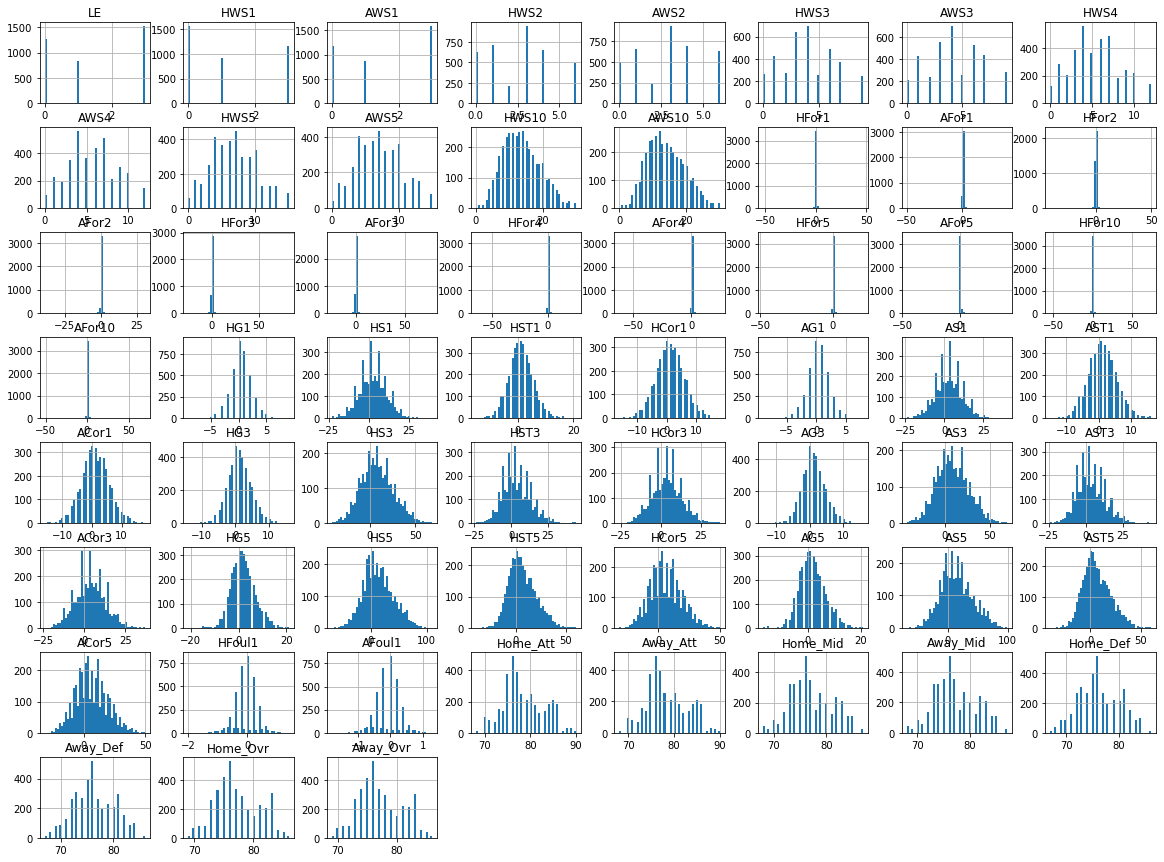

In [30]:
%matplotlib inline 
X.hist(bins=50, figsize=(20,15))
plt.show()


In [31]:
#convert categorical targets into numerical targets (H = 0, A = 1, D = 2)
y_array = y_categorical.to_numpy()
codes, uniques = pd.factorize(y_array)
y = pd.DataFrame(codes)




In [32]:
#split data into training and testing sets
X_np = X.to_numpy()
y_np = y.to_numpy()
np.isnan(X_np)
test = np.where(np.isnan(X_np))

X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

In [33]:
# create copies of the training sets and merge them to perform data visualizattion later
X_visual = X_train.copy()
data_visual = pd.DataFrame(X_visual)
data_visual.columns= ['LE','HWS1','AWS1','HWS2','AWS2','HWS3','AWS3','HWS4','AWS4','HWS5','AWS5','HWS10','AWS10',
            'HFor1','AFor1','HFor2','AFor2','HFor3','AFor3','HFor4','AFor4','HFor5','AFor5','HFor10','AFor10',
            'HG1','HS1','HST1','HCor1','AG1','AS1','AST1','ACor1','HG3','HS3','HST3','HCor3','AG3','AS3','AST3','ACor3',
            'HG5','HS5','HST5','HCor5','AG5','AS5','AST5','ACor5','HFoul1','AFoul1','Home_Att', 'Away_Att', 'Home_Mid', 'Away_Mid',
           'Home_Def', 'Away_Def', 'Home_Ovr', 'Away_Ovr']
data_visual.head()

,LE,HWS1,AWS1,HWS2,AWS2,HWS3,AWS3,HWS4,AWS4,HWS5,...,HFoul1,AFoul1,Home_Att,Away_Att,Home_Mid,Away_Mid,Home_Def,Away_Def,Home_Ovr,Away_Ovr
0,3.0,0.0,0.0,1.0,3.0,2.0,6.0,5.0,9.0,8.0,...,0.4,-0.2,85.0,77.0,80.0,76.0,82.0,77.0,82.0,77.0
1,3.0,1.0,3.0,4.0,3.0,5.0,6.0,6.0,9.0,9.0,...,-0.3,0.0,79.0,89.0,78.0,83.0,77.0,82.0,78.0,83.0
2,3.0,0.0,0.0,3.0,3.0,6.0,4.0,7.0,7.0,8.0,...,-0.4,-0.2,77.0,78.0,77.0,76.0,78.0,76.0,78.0,77.0
3,0.0,0.0,3.0,1.0,3.0,1.0,3.0,4.0,3.0,4.0,...,0.2,0.4,76.0,81.0,73.0,76.0,74.0,76.0,74.0,77.0
4,3.0,0.0,0.0,1.0,3.0,1.0,4.0,4.0,4.0,5.0,...,0.0,-0.2,75.0,73.0,73.0,70.0,71.0,70.0,73.0,71.0


In [34]:
# create a correlation matrix that gives the correlation of each feature with the target
corr_matrix = data_visual.corr()
corr_matrix['Away_Att'].sort_values(ascending=False)




Away_Att    1.000000
Away_Ovr    0.913380
Away_Def    0.862021
Away_Mid    0.856442
AWS10       0.568119
AG5         0.524230
AS5         0.511520
AST5        0.501028
AWS5        0.466581
AS3         0.452340
AG3         0.448131
AST3        0.445804
AWS4        0.429227
ACor5       0.419920
AWS3        0.395177
ACor3       0.352453
AWS2        0.323989
AST1        0.309709
AS1         0.303484
AG1         0.295082
AWS1        0.246292
ACor1       0.226380
LE          0.222005
HFor5       0.052843
HWS2        0.039147
Home_Mid    0.039097
HWS3        0.034820
HG1         0.029473
AFor10      0.028557
Home_Def    0.027106
HCor1       0.027028
HWS4        0.025274
HWS5        0.025116
Home_Ovr    0.024657
HWS1        0.022648
HWS10       0.021936
Home_Att    0.021222
HS1         0.019240
AFor3       0.016738
HCor3       0.011558
HST1        0.011330
HS3         0.010372
HG3         0.009279
HG5         0.008608
HCor5       0.007246
AFor1       0.006070
HS5         0.005519
AFor5       0

In [35]:
# Feature Scaling using minmax scaler (all features will lie in the range [0,1]) 
#--> these new scaled features are not used to train every model because some models don't require scaled features (i.e. Random Forest)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
df_train_scaled = pd.DataFrame(X_train_scaled)
df_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,1.0,0.000000,0.0,0.166667,0.5,0.222222,0.666667,0.416667,0.750000,0.533333,...,0.705882,0.516129,0.772727,0.409091,0.631579,0.421053,0.789474,0.526316,0.764706,0.470588
1,1.0,0.333333,1.0,0.666667,0.5,0.555556,0.666667,0.500000,0.750000,0.600000,...,0.500000,0.580645,0.500000,0.954545,0.526316,0.789474,0.526316,0.789474,0.529412,0.823529
2,1.0,0.000000,0.0,0.500000,0.5,0.666667,0.444444,0.583333,0.583333,0.533333,...,0.470588,0.516129,0.409091,0.454545,0.473684,0.421053,0.578947,0.473684,0.529412,0.470588
3,0.0,0.000000,1.0,0.166667,0.5,0.111111,0.333333,0.333333,0.250000,0.266667,...,0.647059,0.709677,0.363636,0.590909,0.263158,0.421053,0.368421,0.473684,0.294118,0.470588
4,1.0,0.000000,0.0,0.166667,0.5,0.111111,0.444444,0.333333,0.333333,0.333333,...,0.588235,0.516129,0.318182,0.227273,0.263158,0.105263,0.210526,0.157895,0.235294,0.117647


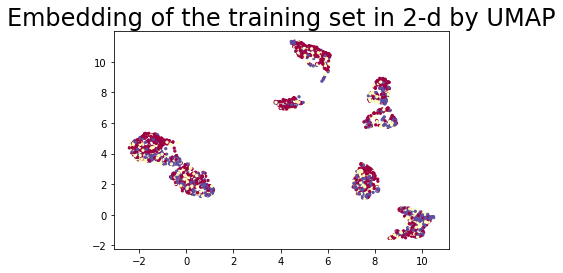

In [36]:
# unsupervised UMAP (uniform manifold approximation and projection ) dimensionality reduction to 2-d
import umap
trans2 = umap.UMAP(n_neighbors = 15,random_state=42, n_components =3).fit(X_train_scaled)
plt.scatter(trans2.embedding_[:, 0], trans2.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')

plt.title('Embedding of the training set in 2-d by UMAP', fontsize=24);

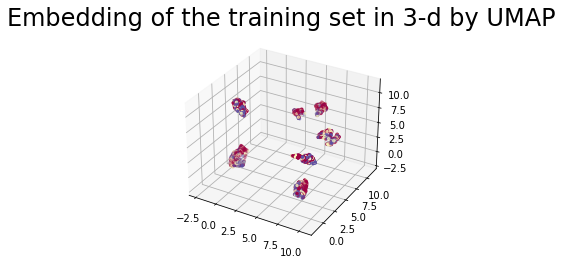

In [37]:
# unsupervised UMAP (uniform manifold approximation and projection ) dimensionality reduction to 3-d
from mpl_toolkits.mplot3d import Axes3D
import umap
trans3 = umap.UMAP(n_neighbors = 15,random_state=42, n_components =3).fit(X_train_scaled)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans3.embedding_[:, 0], trans3.embedding_[:, 1], trans3.embedding_[:, 2], s= 5, c=y_train, cmap='Spectral')
plt.title('Embedding of the training set in 3-d by UMAP', fontsize=24);

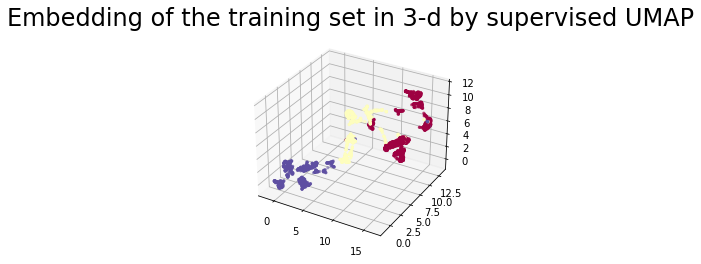

In [38]:
# Supervised UMAP 
import umap
trans3_sup = umap.UMAP(n_neighbors = 15,random_state=42, n_components =3).fit(X_train_scaled, y = y_train)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans3_sup.embedding_[:, 0], trans3_sup.embedding_[:, 1], trans3_sup.embedding_[:, 2], s= 5, c=y_train, cmap='Spectral')
plt.title('Embedding of the training set in 3-d by supervised UMAP', fontsize=24);

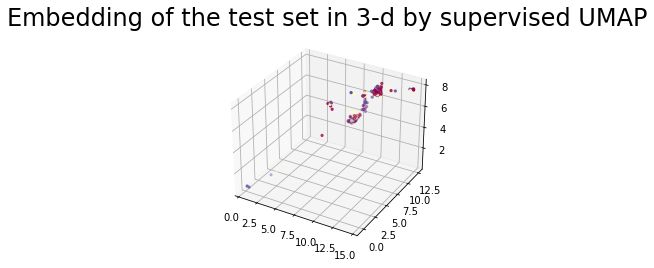

In [39]:
# running the supervised UMAP on the test set (considering it created a beautiful separation in the training set)
# only one cluster with all the data is created --> this is a clear case of overfitting

trans_test = trans3_sup.transform(X_test)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans_test[:, 0], trans_test[:, 1], trans_test[:, 2], s= 5, c=y_test, cmap='Spectral')
plt.title('Embedding of the test set in 3-d by supervised UMAP', fontsize=24);

In [40]:
# running UMAP (unsupervised) to get a 4-d embedding of the features 

trans4 = umap.UMAP(n_neighbors = 15,random_state=42, n_components =3).fit(X_train_scaled)



In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rfc = RandomForestClassifier(n_estimators = 1000)
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=10)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rfc_scores)



/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_va

Scores: [0.52739726 0.51369863 0.53608247 0.53608247 0.48797251 0.54639175
 0.5257732  0.5532646  0.49484536 0.53608247]
Mean: 0.5257590735771783
Standard deviation: 0.020083823776244226


In [42]:
# Logistic Regression with original features

from sklearn.linear_model import LogisticRegression
mlr= LogisticRegression(multi_class = 'multinomial', class_weight = 'balanced')
mlr.fit(X_train, y_train)
predictions = mlr.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57       337
           1       0.29      0.28      0.29       187
           2       0.48      0.61      0.54       204

    accuracy                           0.49       728
   macro avg       0.46      0.47      0.47       728
weighted avg       0.50      0.49      0.49       728

[[178  84  75]
 [ 74  53  60]
 [ 36  43 125]]


/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
# Logistic Regression with UMAP transformed features

from sklearn.linear_model import LogisticRegression
mlr= LogisticRegression(multi_class = 'multinomial', class_weight = 'balanced')
mlr.fit(trans3.embedding_, y_train)
predictions = mlr.predict(trans3.transform(X_test))
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.50      0.88      0.64       337
           1       0.50      0.02      0.03       187
           2       0.40      0.24      0.30       204

    accuracy                           0.48       728
   macro avg       0.46      0.38      0.32       728
weighted avg       0.47      0.48      0.39       728

[[298   0  39]
 [148   3  36]
 [152   3  49]]


In [44]:
# Multi-class linear support vector machine with original features

from sklearn import svm
from sklearn.metrics import r2_score
svc=svm.SVC(random_state = 42, kernel='linear', class_weight = 'balanced')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[[178  91  68]
 [ 74  59  54]
 [ 43  43 118]]
              precision    recall  f1-score   support

           0       0.60      0.53      0.56       337
           1       0.31      0.32      0.31       187
           2       0.49      0.58      0.53       204

    accuracy                           0.49       728
   macro avg       0.47      0.47      0.47       728
weighted avg       0.50      0.49      0.49       728



In [45]:
# Multi-class linear support vector machine with UMAP transformed features 

from sklearn import svm
from sklearn.metrics import r2_score
svc=svm.SVC(random_state = 42, kernel='linear', class_weight = 'balanced')
svc.fit(trans3.embedding_,y_train)
y_pred=svc.predict(trans3.transform(X_test))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[[297  11  29]
 [147  14  26]
 [152  17  35]]
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       337
           1       0.33      0.07      0.12       187
           2       0.39      0.17      0.24       204

    accuracy                           0.48       728
   macro avg       0.41      0.38      0.33       728
weighted avg       0.43      0.48      0.39       728



In [46]:
import xgboost as xgb
xg=xgb.XGBClassifier(seed=2)
xg.fit(X_train,y_train)
y_pred=xg.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AttributeError: dlsym(0x7fb7f9abde50, XGDMatrixCreateFromDense): symbol not found

In [51]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
mnb= GaussianNB()
mnb.fit(X_train, y_train)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[297  11  29]
 [147  14  26]
 [152  17  35]]
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       337
           1       0.33      0.07      0.12       187
           2       0.39      0.17      0.24       204

    accuracy                           0.48       728
   macro avg       0.41      0.38      0.33       728
weighted avg       0.43      0.48      0.39       728



/Users/liuyecan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
